In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Logistic Regression
* We use a `nn.Module` structure for the logistic regression task

In [3]:
class Net(nn.Module):

    def __init__(self, layer_sizes, loss = 'multi_class', bias=True):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.layer_list = []
        self.loss = loss
        self.bias = bias
        self.l1 = nn.Linear(layer_sizes[0], layer_sizes[1],bias = self.bias)

    def forward(self, x):
        x = self.l1(x)

        return x

layer_sizes = [4,3]
net = Net(layer_sizes)
    

print(net)

Net(
  (l1): Linear(in_features=4, out_features=3, bias=True)
)


### Iris data

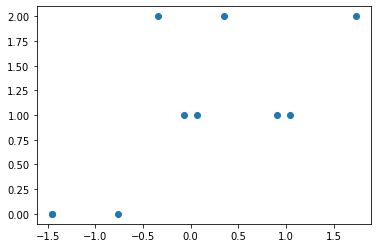

In [4]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 10#50
N_val = 140
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [5]:
## Set hyperparameters for network

tau_list = []
tau = 1.#/100. # iris 1/10
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

## HMC

In [6]:
hamiltorch.set_random_seed(123)
net = Net(layer_sizes)
params_init = hamiltorch.util.flatten(net).to(device).clone()

step_size = 0.1 
num_samples = 300
L = 20
tau_out = 1.

params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 300/300 | 91.35       
Acceptance Rate 0.99


In [7]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=params_hmc[:], model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = torch.zeros( len(pred_list)-1)
nll = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 70 ms, sys: 3.95 ms, total: 74 ms
Wall time: 73 ms


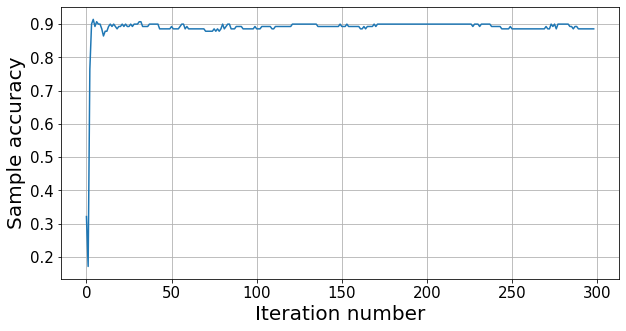

In [8]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

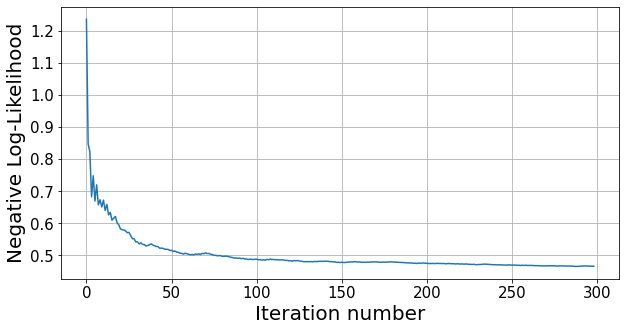

In [9]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log-Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

## Implicit RMHMC
* Initialised from HMC

In [10]:
hamiltorch.set_random_seed(123)
net = Net(layer_sizes)
params_init = hamiltorch.util.flatten(net).to(device).clone()
params_init.shape
# params_init = params_hmc[-100].clone()
print('Parameter size: ',params_init.shape[0])

hamiltorch.set_random_seed(123)
threshold = 1e-3
step_size = 0.1 #0.15
L = 20 #10
num_samples = 300#100
metric = hamiltorch.Metric.HESSIAN
tau_out=1.
softabs_const=10**6

normalizing_const=1.

params_i_rmhmc =hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT,
                                   metric=metric, fixed_point_threshold=threshold, jitter=0.01,
                                   num_steps_per_sample=L, step_size=step_size, softabs_const=softabs_const, tau_out=tau_out,
                                       tau_list=tau_list,debug=False,normalizing_const=normalizing_const)


Parameter size:  15
Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:05:10 | 0d:00:00:00 | #################### | 300/300 | 0.97       
Acceptance Rate 0.99


In [13]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=params_i_rmhmc, model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc_i = torch.zeros( len(pred_list)-1)
nll_i = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc_i[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll_i[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 73.8 ms, sys: 1 µs, total: 73.8 ms
Wall time: 72.7 ms


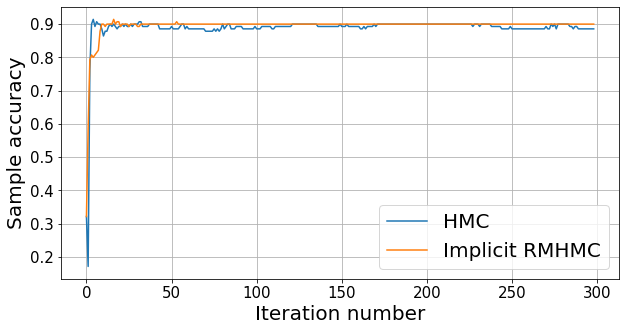

In [14]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc, label = 'HMC')
plt.plot(acc_i, label = 'Implicit RMHMC')
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.xlim([210,300])
plt.legend(fontsize=fs)
plt.show()

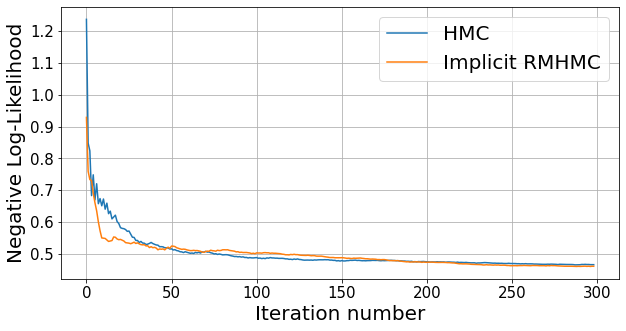

In [15]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll, label = 'HMC')
plt.plot(nll_i, label = 'Implicit RMHMC')
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log-Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.legend(fontsize=fs)
plt.show()

## Explicit RMHMC
* Initialised from HMC

In [16]:
hamiltorch.set_random_seed(123)
net = Net(layer_sizes)
params_init = hamiltorch.util.flatten(net).to(device).clone()
params_init.shape
# params_init = params_hmc[-100].clone()
print('Parameter size: ',params_init.shape[0])

hamiltorch.set_random_seed(123)
threshold = 1e-3
step_size = 0.1#0.15
L = 20 #10
num_samples = 300
metric = hamiltorch.Metric.HESSIAN
tau_out=1.
softabs_const=10**6
omega=1.

params_e_rmhmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.EXPLICIT,
                                   metric=metric, fixed_point_threshold=threshold, jitter=0.01,
                                   num_steps_per_sample=L, step_size=step_size, explicit_binding_const=omega, 
                                   softabs_const=softabs_const,tau_out=tau_out,tau_list=tau_list)

Parameter size:  15
Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:07:06 | 0d:00:00:00 | #################### | 300/300 | 0.71       
Acceptance Rate 1.00


In [17]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x = x_val, y = y_val, samples=params_e_rmhmc, model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc_e = torch.zeros( len(pred_list)-1)
nll_e = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc_e[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll_e[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 73 ms, sys: 0 ns, total: 73 ms
Wall time: 71.9 ms


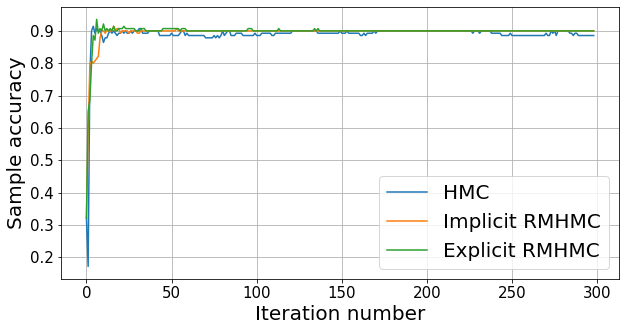

In [18]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc, label = 'HMC')
plt.plot(acc_i, label = 'Implicit RMHMC')
plt.plot(acc_e, label = 'Explicit RMHMC')
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.xlim([210,300])
plt.legend(fontsize=fs)
plt.show()

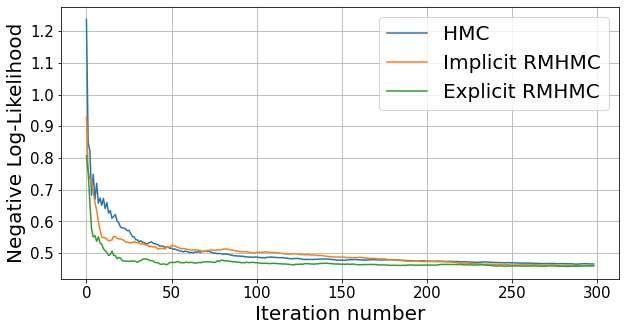

In [19]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll, label = 'HMC')
plt.plot(nll_i, label = 'Implicit RMHMC')
plt.plot(nll_e, label = 'Explicit RMHMC')
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log-Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.legend(fontsize=fs)
plt.show()

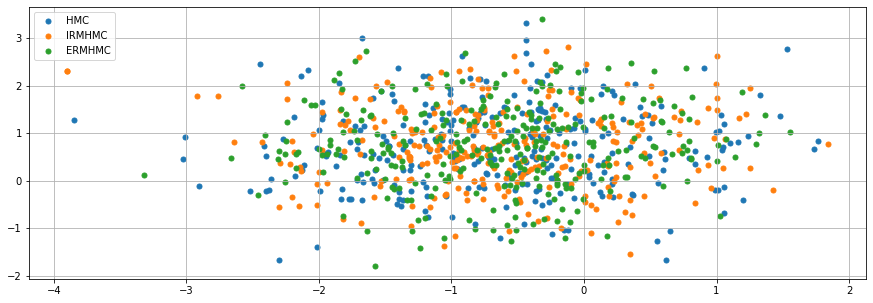

In [20]:
i=0
j=1
plt.figure(figsize=(15,5))
params_h = torch.stack(params_hmc)
params_i = torch.stack(params_i_rmhmc)
params_e = torch.stack(params_e_rmhmc)
plt.scatter(params_h[:,i].numpy(),params_h[:,j].numpy(),s=25,label='HMC')
plt.scatter(params_i[:,i].numpy(),params_i[:,j].numpy(),s=25,label='IRMHMC')
plt.scatter(params_e[:,i].numpy(),params_e[:,j].numpy(),s=25,label='ERMHMC')
plt.legend()
plt.grid()
plt.show()

### Demonstrating HMC over a CNN

* Definitely not optimsed hyperparameters!


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x#torch.softmax(x)
#         return F.log_softmax(x, dim=1)
net = Net()

/home/acobb/miniconda3/envs/hamiltorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


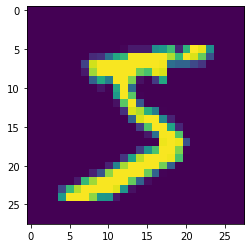

/home/acobb/miniconda3/envs/hamiltorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [22]:
import torchvision
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='../../data', train=False, download=True, transform=None)
plt.imshow(mnist_trainset.train_data[0].reshape((28,28)))
plt.show()
D = 784
N_tr = 100
N_val = 1000


x_train = mnist_trainset.train_data[:N_tr].float()/255.
x_train = x_train[:,None]
y_train = mnist_trainset.train_labels[:N_tr].reshape((-1,1)).float()
x_val = mnist_trainset.train_data[N_tr:N_tr+N_val].float()/255.
x_val = x_val[:,None]
y_val = mnist_trainset.train_labels[N_tr:N_tr+N_val].reshape((-1,1)).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [23]:
tau_list = []
tau = 10.#./100. # 1/50
for w in net.parameters():
#     print(w.nelement())
#     tau_list.append(tau/w.nelement())
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [24]:
hamiltorch.set_random_seed(123)
net = Net()
params_init = hamiltorch.util.flatten(net).to(device).clone()
print(params_init.shape)

step_size = 0.001#0.01# 0.003#0.002
num_samples = 300#2000 # 3000
L = 20 #3
tau_out = 1.
normalizing_const = 1.
burn =0 #GPU: 3000

params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)


torch.Size([431080])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:26 | 0d:00:00:00 | #################### | 300/300 | 11.22       
Acceptance Rate 0.96


In [25]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x = x_val, y = y_val, samples=params_hmc, model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = []
acc = torch.zeros( int(len(params_hmc))-1)
nll = torch.zeros( int(len(params_hmc))-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(params_hmc)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 901 ms, sys: 436 ms, total: 1.34 s
Wall time: 1.34 s


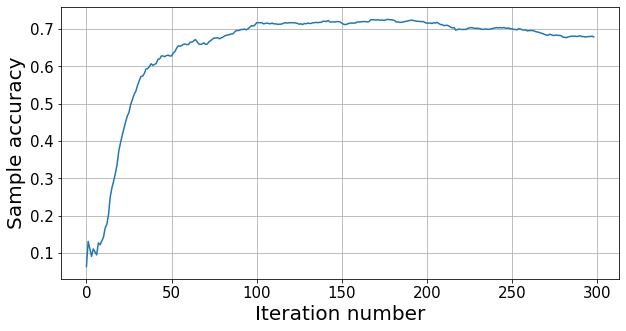

In [26]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

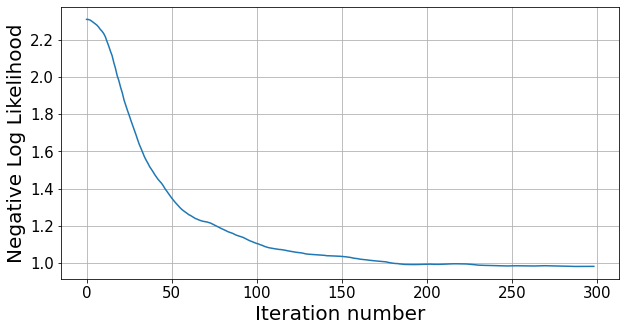

In [27]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

## HMC Regression example

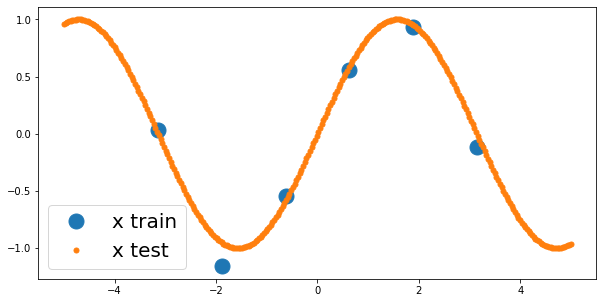

In [28]:
N_tr = 6
N_val = 300


x_val = torch.linspace(-5,5,N_val).view(-1,1)
y_val = torch.sin(x_val).view(-1,1)

x_train = torch.linspace(-3.14,3.14,N_tr).view(-1,1)
y_train = torch.sin(x_train).view(-1,1) + torch.randn_like(x_train)*0.1

plt.figure(figsize=(10,5))
plt.plot(x_train.numpy(),y_train.numpy(),'.',markersize=30, label='x train')
plt.plot(x_val.numpy(),y_val.numpy(),'.',markersize=10, label='x test')

plt.legend(fontsize=20)
plt.show()

x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)



In [29]:
class Net(nn.Module):

    def __init__(self, layer_sizes, loss = 'multi_class', bias=True):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.layer_list = []
        self.loss = loss
        self.bias = bias
#         for l in range(len(layer_sizes[:-1])):
#         self.layer_list.append(
        self.l1 = nn.Linear(layer_sizes[0], layer_sizes[1],bias=True)
        self.l2 = nn.Linear(layer_sizes[1], layer_sizes[2],bias = self.bias)
        self.l3 = nn.Linear(layer_sizes[2], layer_sizes[3],bias = self.bias)
#         self.l4 = nn.Linear(layer_sizes[3], layer_sizes[4],bias = self.bias)

    def forward(self, x):
#         for layer in self.layer_list[:-1]:
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        
        return x

layer_sizes = [1,10,10,1]
net = Net(layer_sizes, loss='regression').to(device)

params_init = hamiltorch.util.flatten(net).to(device).clone()
print('Parameter size: ',params_init.shape[0])

Parameter size:  141


In [30]:
tau_list = []
tau = 1.
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [31]:
step_size = 0.00512
num_samples = 300#0
L = 20
tau_out = 100. #10.

hamiltorch.set_random_seed(123)
net = Net(layer_sizes, loss='regression')
params_init = hamiltorch.util.flatten(net).to(device).clone()
print('Parameter size: ',params_init.shape[0])

params_hmc = hamiltorch.sample_model(net, x_train, y_train, model_loss='regression',params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,normalizing_const=N_tr, tau_list=tau_list)


Parameter size:  141
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:15 | 0d:00:00:00 | #################### | 300/300 | 19.20       
Acceptance Rate 0.68


In [32]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, model_loss='regression', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)

print(tau_list[0])
print(tau_out)
print('\nExpected validation log probability: {:.2f}'.format(torch.stack(log_prob_list).mean()))
print('\nExpected MSE: {:.2f}'.format(((pred_list.mean(0) - y_val)**2).mean()))

CPU times: user 260 ms, sys: 32 ms, total: 292 ms
Wall time: 291 ms
tensor(1., device='cuda:0')
100.0

Expected validation log probability: -2241.74

Expected MSE: 0.03


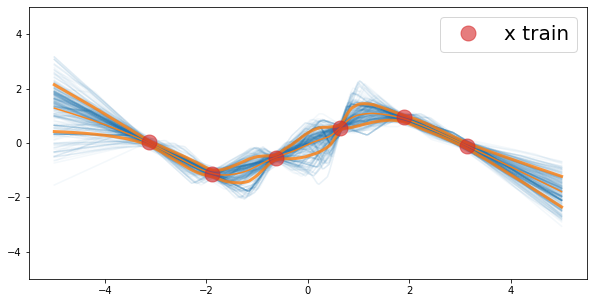

In [33]:
burn = 10

plt.figure(figsize=(10,5))
plt.plot(x_val.cpu().numpy(),pred_list[burn:].cpu().numpy().squeeze().T, 'C0',alpha=0.051)
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T +pred_list.std(0).cpu().numpy().squeeze().T, 'C1',alpha=0.8,linewidth=3)
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T -pred_list.std(0).cpu().numpy().squeeze().T, 'C1',alpha=0.8,linewidth=3)

plt.plot(x_train.cpu().numpy(),y_train.cpu().numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.ylim([-5,5])
plt.show()